详细可见文件夹下的Readme.md <br>
数据下载时间很长，建议直接把./data/文件夹复制到jupyternotebook相同目录下

## 1. 数据爬取脚本

In [ ]:
from tqdm import tqdm
import pandas as pd
import requests
import json
import time
import numpy as np
import os

def make_url(stamp_start, stamp_end, crypto_id, convert_id=2781):
    return f"https://api.coinmarketcap.com/data-api/v3.1/cryptocurrency/historical?id={crypto_id}&convertId={convert_id}&timeStart={stamp_start}&timeEnd={stamp_end}&interval=1d"

def make_time_range(start, end):
    start = pd.to_datetime(start) - pd.offsets.Day(1)
    end = pd.to_datetime(end)
    date_range = pd.date_range(start, end, freq="YS").to_list()
    date_range = [start] + date_range + [end]
    date_range = np.array(sorted(list(set(date_range))))
    starts = date_range[:-1]
    starts = [int(i.timestamp()) for i in starts]
    ends = np.roll(date_range, -1)[:-1]
    ends = [int(i.timestamp()) for i in ends]
    return list(zip(starts, ends))

def parse_json(data):
    if "data" not in data or "quotes" not in data["data"]:
        return pd.DataFrame(), "Unknown"
    
    quotes = data["data"]["quotes"]
    if len(quotes) == 0:
        return pd.DataFrame(), data["data"].get("name", "Unknown")
    
    code = data["data"]["id"]
    name = data["data"]["name"]
    symbol = data["data"]["symbol"]
    
    record_ls = []
    for record in quotes:
        record_ls.append(record["quote"])
    
    df = pd.DataFrame(record_ls)
    df["timestamp"] = pd.to_datetime(df["timestamp"].str[:10], utc=True)
    df["name"] = name
    df["code"] = code
    df["symbol"] = symbol
    
    return df, name

def validate_data(df, start_date, end_date):
    if df.empty:
        print("Empty DataFrame")
        return False
    
    start_utc = pd.to_datetime(start_date, utc=True).date()
    end_utc = pd.to_datetime(end_date, utc=True).date()
    
    first_date = df['timestamp'].iloc[0].date()
    last_date = df['timestamp'].iloc[-1].date()
    
    if (first_date != start_utc) or (last_date != end_utc):
        print(f"Expected: {start_utc} - {end_utc}, Got: {first_date} - {last_date}")
        return False
    
    expected_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    if len(df) < expected_days:
        print(f"Expected: {expected_days} days, Got: {len(df)} days")
        return False
    
    # 加入市值规模验证，仅保留市值大于1m的数据
    if df['marketCap'].min() < 1e6:
        print(f"Market cap too small: {df['market_cap'].min()}")
        return False

    return True


if __name__ == "__main__":

    success_count = 0
    if not os.path.exists("./data"):
        os.makedirs("./data")

    for code in tqdm(range(1, 2000), desc="Crawling"):
        if success_count >= 100:
            break
        try:
            time_range = make_time_range("2020-03-05", "2025-03-05")
            df_ls = []
            for start, end in time_range:
                url = make_url(start, end, code)
                r = requests.get(url, timeout=10)
                r.raise_for_status()
                data = json.loads(r.text)
                df_chunk, name = parse_json(data)
                if not df_chunk.empty:
                    df_ls.append(df_chunk)
                time.sleep(2)  
            
            if not df_ls:
                continue
                
            res = pd.concat(df_ls).sort_values('timestamp')
            
            # 数据验证
            if validate_data(res, "2020-03-05", "2025-03-05"):
                res.to_csv(f"./data/code{code}_{name}.csv", index=False)
                success_count += 1
                print(f"\n成功保存: code{code}_{name}")
            else:
                print(f"\n数据验证失败: code{code}_{name}")
                
        except (requests.exceptions.RequestException, 
                json.JSONDecodeError,
                KeyError,
                pd.errors.EmptyDataError) as e:
            print(f"\n跳过 code{code}: {str(e)[:50]}...")
            continue


## 2. 零投资策略

加密货币计算因子中...: 100%|███████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.25it/s]


列 index 全为 NaN，跳过处理
列 2020-03-02 00:00:00 全为 NaN，跳过处理
MCAP策略的周平均收益率为0.0063865607465357745
年化收益率: 0.3159
夏普比率: 0.9384
卡玛比率: 0.8027
列 index 全为 NaN，跳过处理
列 2020-03-02 00:00:00 全为 NaN，跳过处理
MAXDPRC策略的周平均收益率为0.006994776955259325
年化收益率: 0.3473
夏普比率: 0.9599
卡玛比率: 1.1823
列 index 全为 NaN，跳过处理
列 2020-03-02 00:00:00 全为 NaN，跳过处理
列 2020-03-09 00:00:00 全为 NaN，跳过处理
mom_r_1_0策略的周平均收益率为-0.006522306606803832
年化收益率: -0.3540
夏普比率: -0.7969
卡玛比率: -0.3809
列 index 全为 NaN，跳过处理
列 2020-03-02 00:00:00 全为 NaN，跳过处理
列 2020-03-09 00:00:00 全为 NaN，跳过处理
列 2020-03-16 00:00:00 全为 NaN，跳过处理
mom_r_2_0策略的周平均收益率为-0.008878905388179667
年化收益率: -0.4238
夏普比率: -1.1786
卡玛比率: -0.4466
列 index 全为 NaN，跳过处理
列 2020-03-02 00:00:00 全为 NaN，跳过处理
PRCVOL策略的周平均收益率为0.00987751215829589
年化收益率: 0.5518
夏普比率: 1.2732
卡玛比率: 2.1407


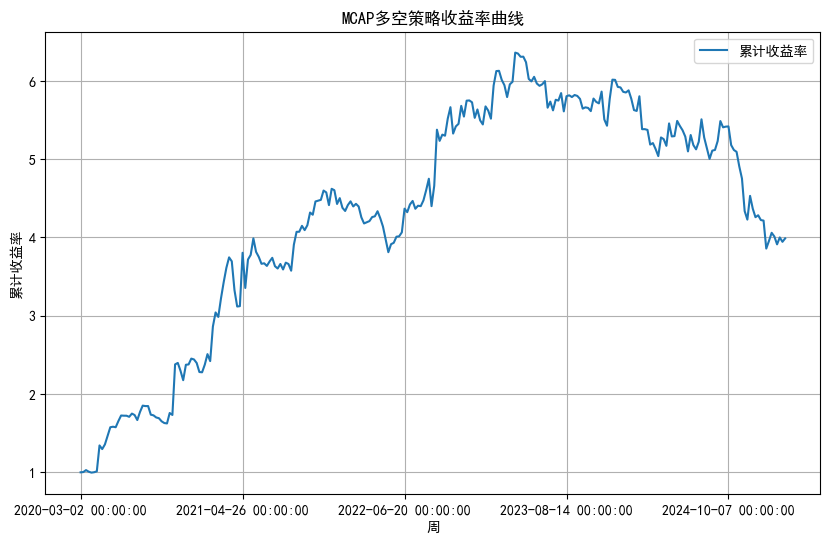

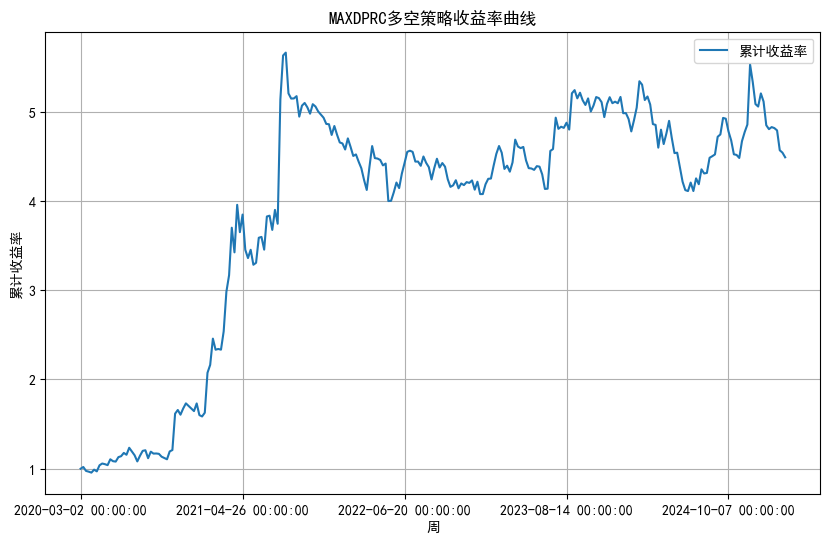

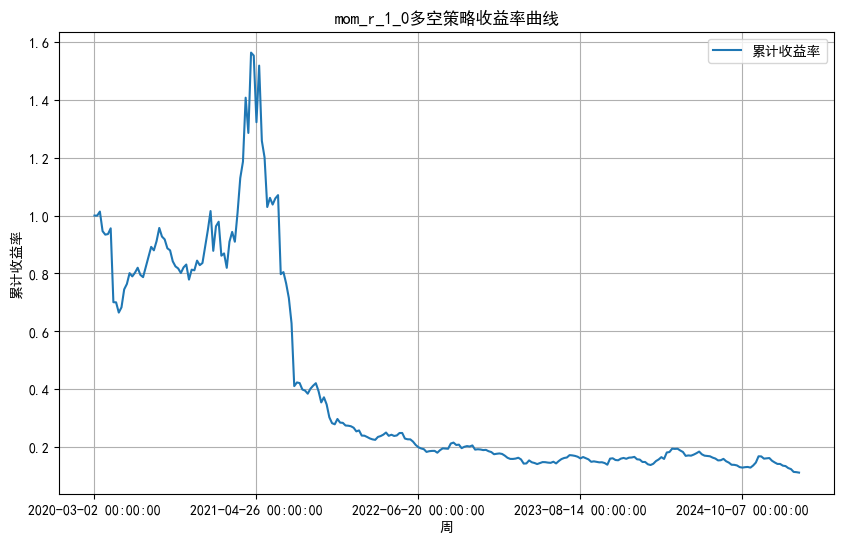

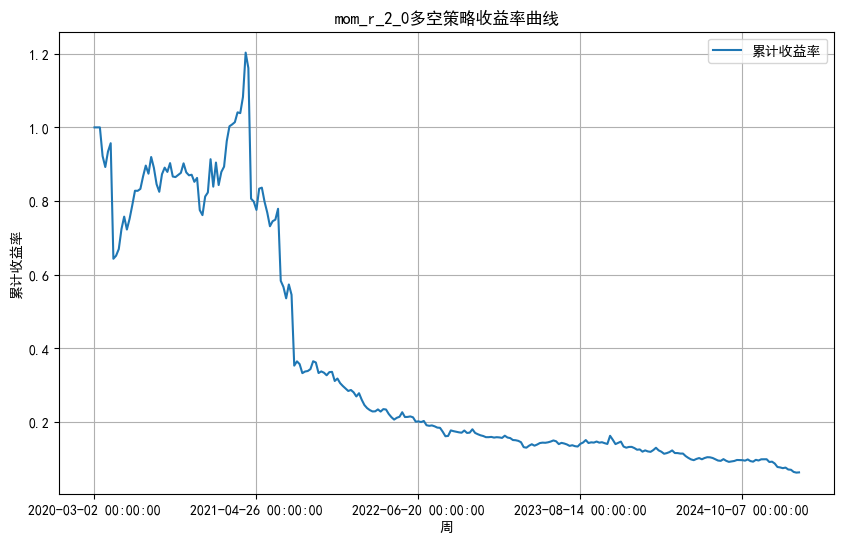

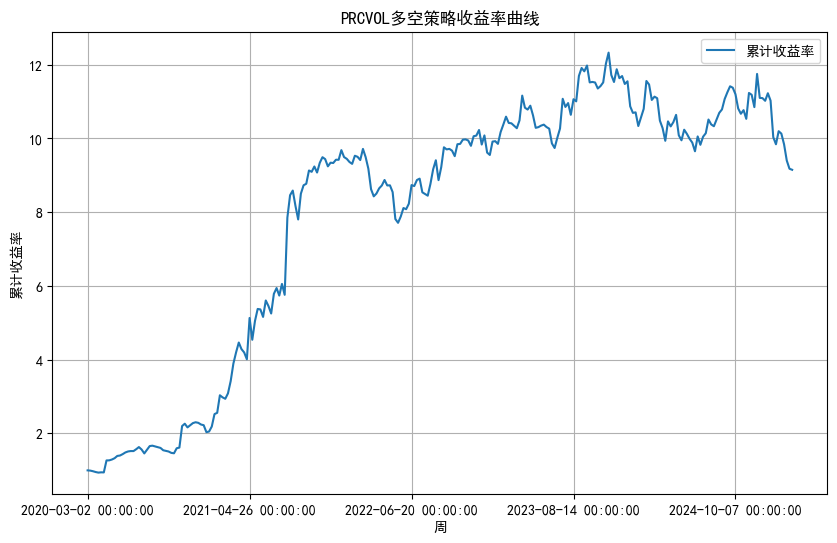

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", message="Converting to PeriodArray/Index representation will drop timezone information")

import os
import re

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 设置全局字体为支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

__eps__ = 1e-10

class crypto_currency:
    '''
    crypto_currency class: 用于存储单个加密货币的数据，并计算相关指标，例如每日收益率
    '''
    def __init__(self, code, name, file_path=None):
        self.code = code
        self.name = name
        self.df = pd.read_csv(f"{file_path}/code{code}_{name}.csv")
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        
        self.df = self.df.sort_values(by='timestamp', ascending=True)

        self.begin_date = self.df['timestamp'].iloc[0]
        self.end_date = self.df['timestamp'].iloc[-1]

    def get_daily_return(self, periods=1):
        # 每日收益率计算
        self.df['daily_return'] = self.df['close'].pct_change(periods=periods)

    def get_weekly_return(self):
        df = self.df.copy()
        df['week'] = df['timestamp'].dt.to_period('W').dt.start_time

        weekly_return = (
            df.groupby('week')['daily_return'].transform(
            lambda x: (1 + x).prod() - 1)
            .reset_index(name='weekly_return')  # 复利计算周收益
        )

        df['weekly_return'] = weekly_return['weekly_return']
        self.df = df

class predictor:
    '''
    predictor class: 用于生成因子，方便后续扩展其他因子
    输入：crypto_currency类实例
    输出：带有有关因子的crypto_currency类实例
    '''
    def __init__(self, crypto_currency):
        self.crypto_currency = crypto_currency
        
    def get_predictor_MCAP(self, predictor_name='MCAP'):
        # MCAP因子计算: 上周的对数市值
        df = self.crypto_currency.df.copy()
        df['week'] = df['timestamp'].dt.to_period('W').dt.start_time
        
        # 计算每周最后一天的市值，并滞后一周
        weekly_last_mcap = (
            df.groupby('week')['marketCap'].last()  
            .shift(1)                               
            .reset_index(name='last_mcap')
        )
        
        df = df.merge(weekly_last_mcap, on='week', how='left')
        
        # 计算MCAP因子
        df[predictor_name] = np.log(df['last_mcap']+__eps__)

        df.drop(columns=['last_mcap'], inplace=True)
        self.crypto_currency.df = df

    def get_predictor_MAXDPRC(self, predictor_name='MAXDPRC'):
        # MAXDPRC因子计算: 上周的对数最高价
        df = self.crypto_currency.df.copy()
        df['week'] = df['timestamp'].dt.to_period('W').dt.start_time
        
        # 计算每周最高价，并滞后一周
        weekly_last_maxdprc = (
            df.groupby('week')['high'].max()  
            .shift(1)                               
            .reset_index(name='last_maxdprc')
        )
        df = df.merge(weekly_last_maxdprc, on='week', how='left')
        
        # 计算MCAP因子
        df[predictor_name] = np.log(df['last_maxdprc']+__eps__)

        df.drop(columns=['last_maxdprc'], inplace=True)
        self.crypto_currency.df = df

    def get_predictor_mom_r_1_0(self, predictor_name='mom_r_1_0'):
        # mom_r_1_0因子计算: 过去1周的收益率
        df = self.crypto_currency.df.copy()

        df['week'] = df['timestamp'].dt.to_period('W').dt.start_time

        weekly_return = (
            df.groupby('week')['daily_return'].apply(
                lambda x: (1 + x).prod() - 1 if len(x) == 7 else None
            ).reset_index(name=predictor_name)
        )

        weekly_return[predictor_name] = weekly_return[predictor_name].shift(1)

        df = df.merge(weekly_return, on='week', how='left')

        self.crypto_currency.df = df

    def get_predictor_mom_r_2_0(self, predictor_name='mom_r_2_0'):
        # mom_r_2_0因子计算: 过去两周的收益率
        df = self.crypto_currency.df.copy()

        df['two_weeks'] = df['timestamp'].dt.to_period('W').astype('datetime64[ns]')
        df['two_weeks'] = df.groupby(pd.Grouper(key='two_weeks', freq='2W'))['two_weeks'].transform('first')

        two_weeks_return = (
            df.groupby('two_weeks')['daily_return'].apply(
                lambda x: (1 + x).prod() - 1 if len(x) == 14 else None
            ).reset_index(name=predictor_name)
        )

        # 滞后两周
        two_weeks_return[predictor_name] = two_weeks_return[predictor_name].shift(1)

        df = df.merge(two_weeks_return, on='two_weeks', how='left')

        self.crypto_currency.df = df

    def get_predictor_PRCVOL(self, predictor_name='PRCVOL'):
        # PRCVOL因子计算: 上周的对数平均价格乘以成交量
        df = self.crypto_currency.df.copy()
        df['week'] = df['timestamp'].dt.to_period('W').dt.start_time

        df['prcvol_daily'] = df['close'] * df['volume']

        weekly_prcvol = (
            df.groupby('week')['prcvol_daily'].mean()
            .shift(1).reset_index(name='last_prcvol_weekly')
        )

        df = df.merge(weekly_prcvol, on='week', how='left')

        df[predictor_name] = np.log(df['last_prcvol_weekly']+__eps__)

        self.crypto_currency.df = df


def day2week(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')

    # 定义各列的聚合规则
    agg_rules = {
        'open': 'first',
        'high': 'max',
        'low': 'min', 
        'close': 'last',
        'volume': 'sum',
        'daily_return': 'last',
        'MCAP': 'last',
        'MAXDPRC': 'last',
        'mom_r_1_0': 'last',
        'mom_r_2_0': 'last',
        'PRCVOL': 'last',
        'weekly_return': 'last'
    }

    week_df = df.resample('7d', offset='-3d').agg(agg_rules)

    week_df = week_df.dropna(how='all')

    week_df = week_df.reset_index()
    week_df['timestamp'] = week_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    return week_df


class zero_investment_strategy:
    '''
    输入：带有有关因子的crypto_currency类实例存储的list
    输出：零投资多头策略的周收益率
    具体操作：生成两个矩阵，一个存储投资组合权重，行为各加密货币，列为时间；另一个存储每周收益率，行各加密货币，列为时间。
    每个时间点的加密货币的收益，即为两矩阵的哈达玛积
    其中，做多因子值最高的10个加密货币，做空因子值最低的10个加密货币，权重分别为1/20(多)和-1/20(空)
    '''
    def __init__(self, crypto_currency_list):
        for c in crypto_currency_list:
            ## 转为周频数据
            c.df = day2week(df=c.df)
        
        self.cc_class_list = crypto_currency_list
        self.time_list = self.cc_class_list[0].df['timestamp'].unique()
        self.cc_list = [cc.name for cc in self.cc_class_list]

    def get_factor_matrix(self, factor='MCAP'):
        # 生成因子矩阵
        factor_matrix = [[float(c.df[c.df['timestamp']==t][factor].values) for c in self.cc_class_list] for t in self.time_list]
        factor_df = pd.DataFrame(factor_matrix, columns=self.cc_list, index=self.time_list).T
        # print(factor_df.iloc[:, :5])
        return factor_df
        
    def get_weight_matrix(self, factor='MCAP'):
        # 生成投资组合权重矩阵: 由因子矩阵生成
        df = self.get_factor_matrix(factor=factor)
        df.reset_index(inplace=True)

        # 遍历每一列
        for col in df.columns:
            col_series = pd.to_numeric(df[col], errors='coerce')
            
            if col_series.isna().all():
                print(f"列 {col} 全为 NaN，跳过处理")
                continue

            top_10_indices = col_series.nlargest(10).index
            bottom_10_indices = col_series.nsmallest(10).index

            if factor == 'MCAP' or factor == 'MAXDPRC' or factor == 'PRCVOL':
                ## 五个因子中MCAP, MAXDPRC, PRCVOL因子需要做多因子小的，做空因子大的，所以需要调换
                temp_top_10_indices = top_10_indices
                top_10_indices = bottom_10_indices
                bottom_10_indices = temp_top_10_indices

            df.loc[:, col] = 0.0

            # 做多最大的10个
            df.loc[top_10_indices, col] = 0.05

            # 做空最小的10个
            df.loc[bottom_10_indices, col] = -0.05

        df.set_index('index', inplace=True)
        self.weight_df = df     

    def get_return_matrix(self):
        # 生成收益率矩阵
        return_matrix = [[float(c.df[c.df['timestamp']==t]['weekly_return'].values) for c in self.cc_class_list] for t in self.time_list]
        return_df = pd.DataFrame(return_matrix, columns=self.cc_list, index=self.time_list).T
        # print(return_df)
        self.return_df = return_df

    def zero_investment_stragety(self, factor='MCAP'):
        # 单因子零投资多空策略，计算其收益率
        self.get_weight_matrix(factor=factor)
        self.get_return_matrix()

        # 哈达玛积计算收益率
        self.strategy_return_df = self.weight_df * self.return_df
        self.strategy_time_return = self.strategy_return_df.sum(axis=0)


def get_eval_result(df, factor='factor'):
    df['cumulative_return'] = (1 + df['weekly_return']).cumprod()

    # 计算年化收益率
    annualized_return = (df['cumulative_return'].iloc[-1]) ** (52 / len(df)) - 1

    # 计算夏普比率（假设无风险利率为0）
    sharpe_ratio = np.sqrt(52) * (df['weekly_return'].mean() / df['weekly_return'].std())

    # 计算最大回撤
    df['cumulative_max'] = df['cumulative_return'].cummax()
    df['drawdown'] = df['cumulative_return'] / df['cumulative_max'] - 1
    max_drawdown = df['drawdown'].min()

    # 计算卡玛比率
    calmar_ratio = annualized_return / abs(max_drawdown+__eps__)

    print(f"年化收益率: {annualized_return:.4f}")
    print(f"夏普比率: {sharpe_ratio:.4f}")
    print(f"卡玛比率: {calmar_ratio:.4f}")

    # 绘制收益率曲线
    plt.figure(figsize=(10, 6))
    plt.plot(df['cumulative_return'], label='累计收益率')
    plt.title('收益率曲线')
    plt.xlabel('周')
    plt.ylabel('累计收益率')
    plt.legend()
    plt.grid()
    plt.title(f"{factor}多空策略收益率曲线")

    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))  

    # plt.show()
    folder_path = "./figures/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.savefig(f"{folder_path}{factor}.png")



if __name__ == "__main__":
    ### zero_investment_strategy test

    folder_path = "./data/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    cc_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    def cc_preprocess(cc):
        # 正则匹配
        pattern = r"^code(\d+)_(.+)\.csv$"
        match = re.match(pattern, cc)
        # 实例化
        number = match.group(1)
        name = match.group(2)
        test = crypto_currency(number, name, file_path=folder_path)
        test.get_daily_return()
        test.get_weekly_return()
        # 计算predictor
        test_predictor = predictor(test)
        test_predictor.get_predictor_MCAP()
        test_predictor.get_predictor_MAXDPRC()
        test_predictor.get_predictor_mom_r_1_0()
        test_predictor.get_predictor_mom_r_2_0()
        test_predictor.get_predictor_PRCVOL()

        return test_predictor.crypto_currency

    test_list = []
    for cc in tqdm(cc_list, desc='加密货币计算因子中...'):
        test_list.append(cc_preprocess(cc))
    
    # fetch_num = 50
    # test_list = test_list[:fetch_num]  # 只取50个
    # print(f"纳入分析的加密货币有{len(test_list)}个, \n 具体为{cc_list[:fetch_num]}")
    
    test_zis = zero_investment_strategy(test_list)
    test_zis.zero_investment_stragety(factor='MCAP')
    print(f"MCAP策略的周平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result(pd.DataFrame(test_zis.strategy_time_return, columns=['weekly_return']), factor='MCAP')

    test_zis.zero_investment_stragety(factor='MAXDPRC')
    print(f"MAXDPRC策略的周平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result(pd.DataFrame(test_zis.strategy_time_return, columns=['weekly_return']), factor='MAXDPRC')

    test_zis.zero_investment_stragety(factor='mom_r_1_0')
    print(f"mom_r_1_0策略的周平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result(pd.DataFrame(test_zis.strategy_time_return, columns=['weekly_return']), factor='mom_r_1_0')

    test_zis.zero_investment_stragety(factor='mom_r_2_0')
    print(f"mom_r_2_0策略的周平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result(pd.DataFrame(test_zis.strategy_time_return, columns=['weekly_return']), factor='mom_r_2_0')

    test_zis.zero_investment_stragety(factor='PRCVOL')
    print(f"PRCVOL策略的周平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result(pd.DataFrame(test_zis.strategy_time_return, columns=['weekly_return']), factor='PRCVOL')
    

## 3. PPS策略

加密货币计算因子中...: 100%|███████████████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.31it/s]


开始计算return matrix...
开始计算factor matrix...
开始计算rolling pred return matrix...
MCAP策略的天平均收益率为0.002074832408505362
年化收益率: 0.6556
夏普比率: 1.0759
卡玛比率: 0.9015
开始计算return matrix...
开始计算factor matrix...
开始计算rolling pred return matrix...
MCAP策略-alpha的天平均收益率为0.002284806707606121
年化收益率: 0.7889
夏普比率: 1.1881
卡玛比率: 1.0832
开始计算return matrix...
开始计算factor matrix...
开始计算rolling pred return matrix...
MCAP策略-beta的天平均收益率为0.0022545899850887783
年化收益率: 0.7596
夏普比率: 1.1573
卡玛比率: 1.0611
开始计算return matrix...
开始计算factor matrix...
开始计算rolling pred return matrix...
MAXDPRC策略的天平均收益率为0.0018337723453069976
年化收益率: 0.5170
夏普比率: 0.9521
卡玛比率: 0.6638
开始计算return matrix...
开始计算factor matrix...
开始计算rolling pred return matrix...
MAXDPRC策略-alpha的天平均收益率为0.0022102275270285657
年化收益率: 0.7456
夏普比率: 1.1541
卡玛比率: 1.0295
开始计算return matrix...
开始计算factor matrix...
开始计算rolling pred return matrix...
MAXDPRC策略-beta的天平均收益率为0.002440922816602454
年化收益率: 0.8852
夏普比率: 1.2549
卡玛比率: 1.2153
开始计算return matrix...
开始计算factor matrix...
开始计算rolling pred r

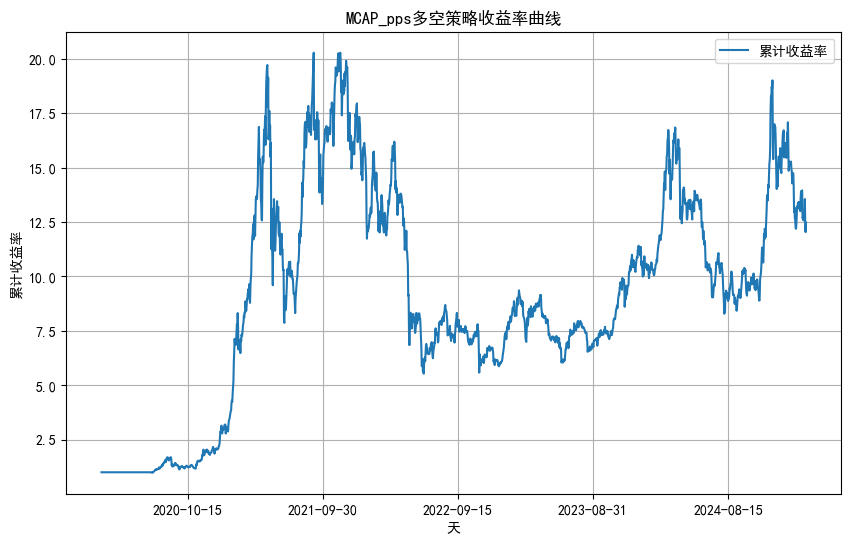

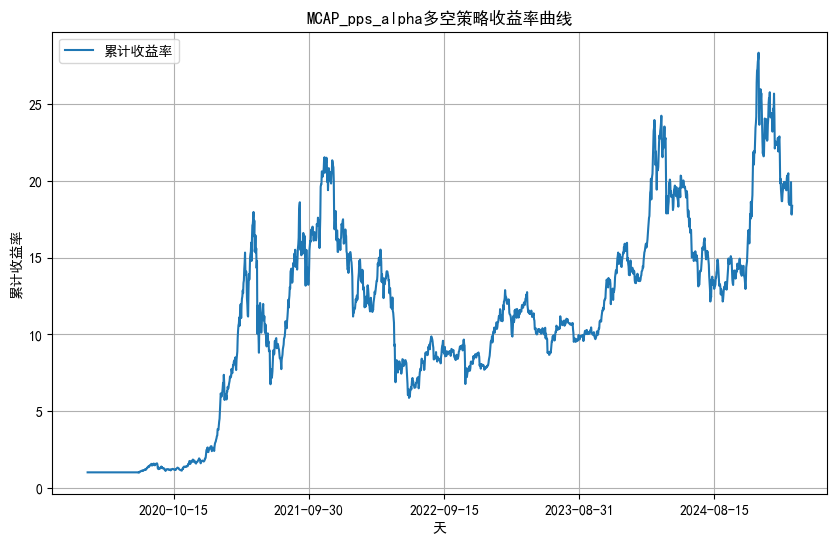

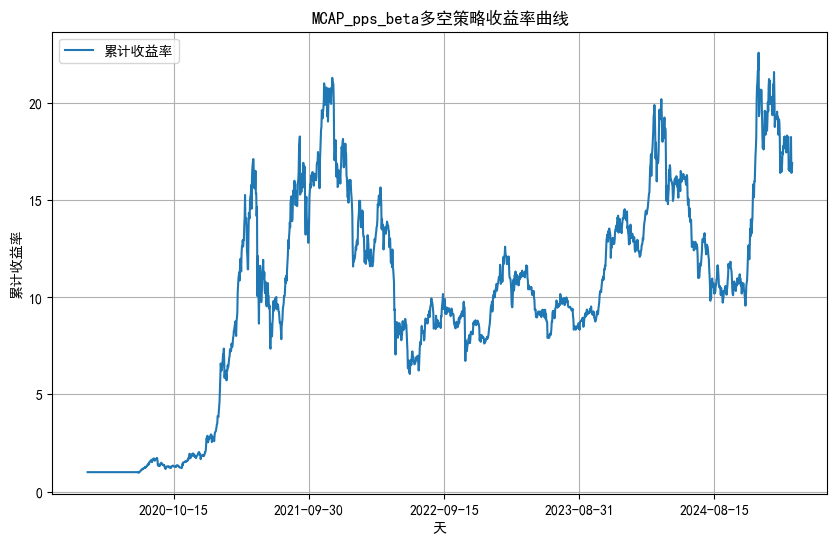

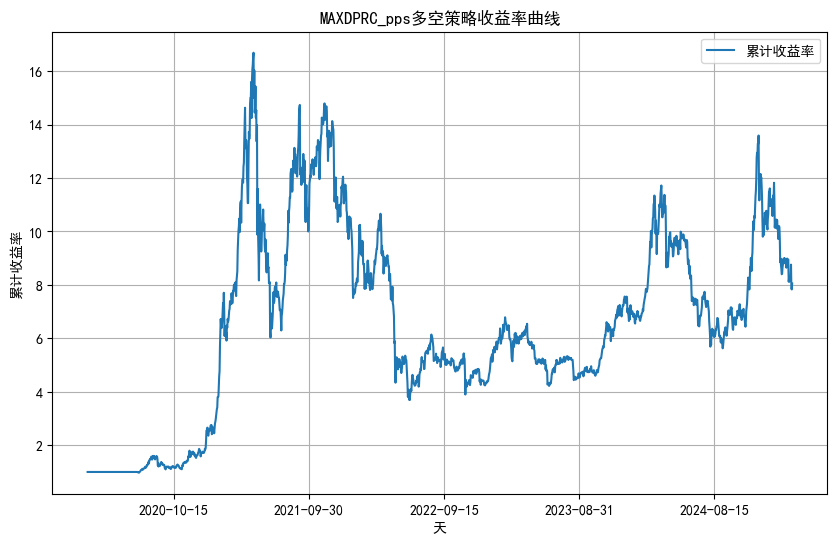

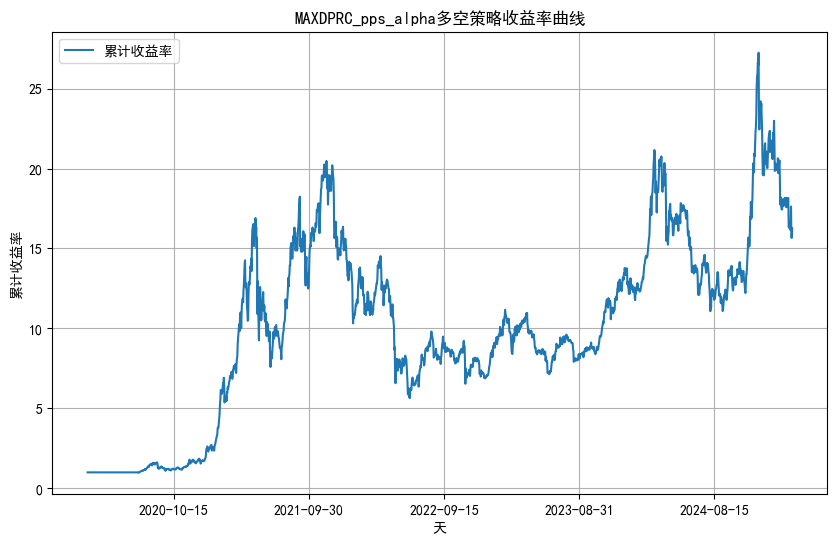

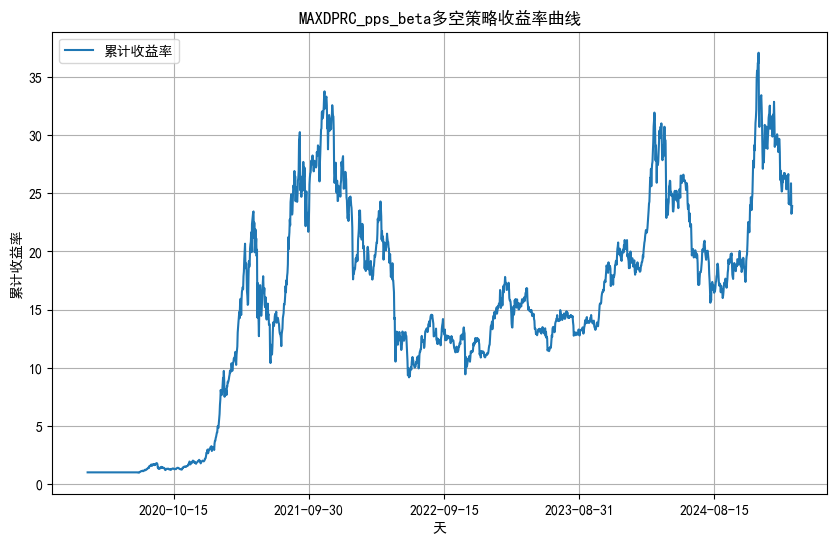

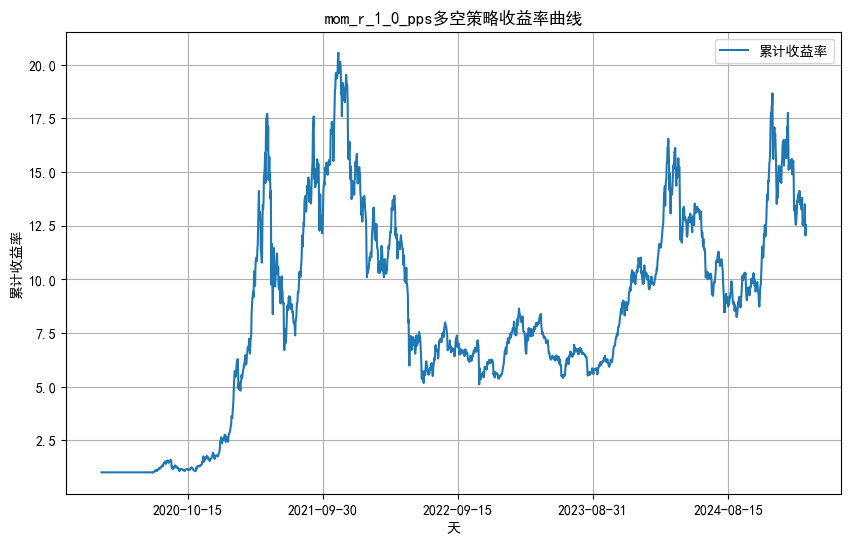

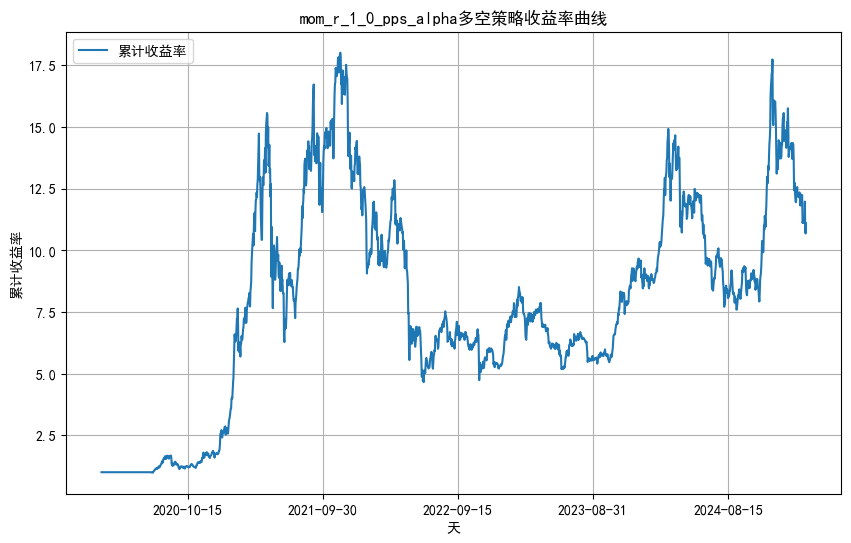

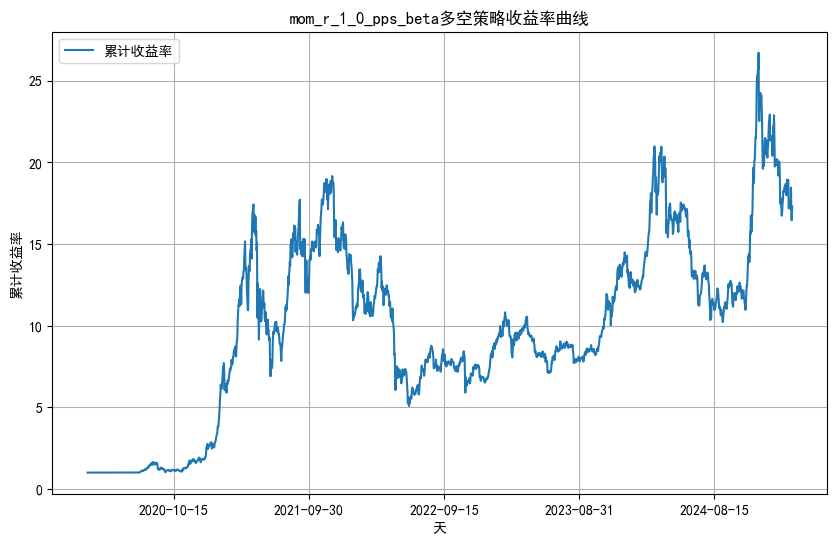

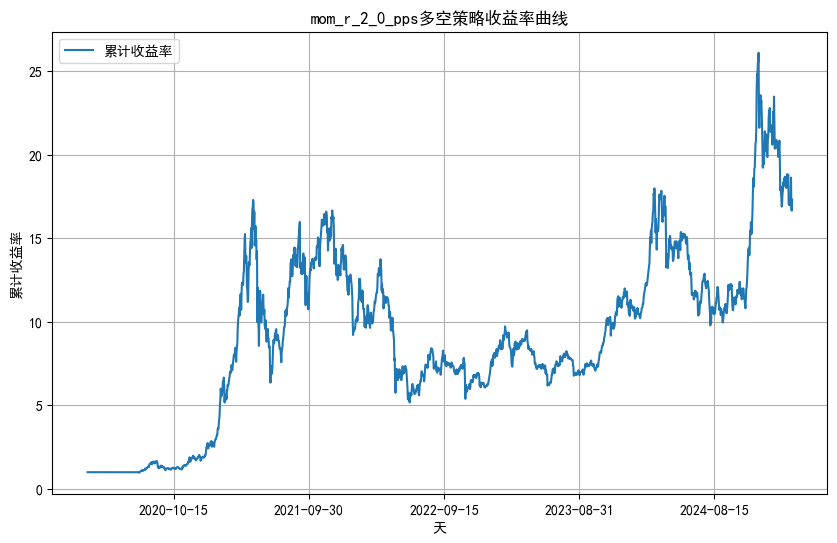

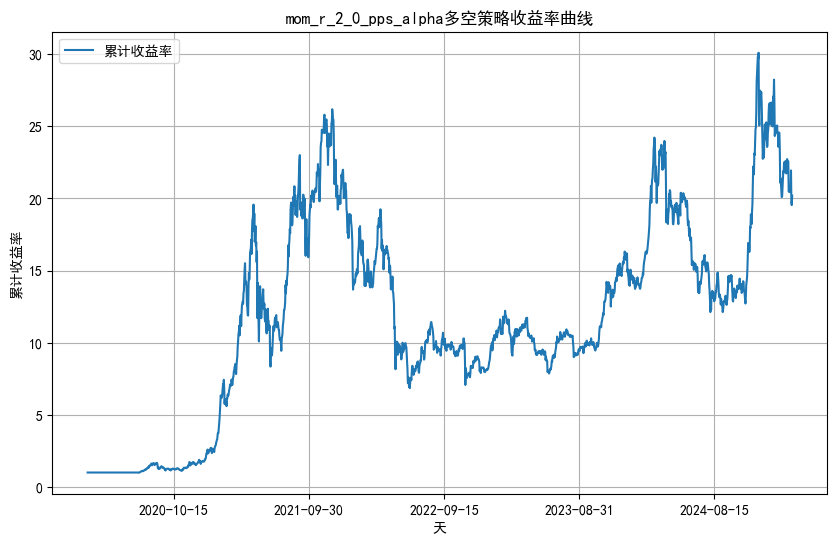

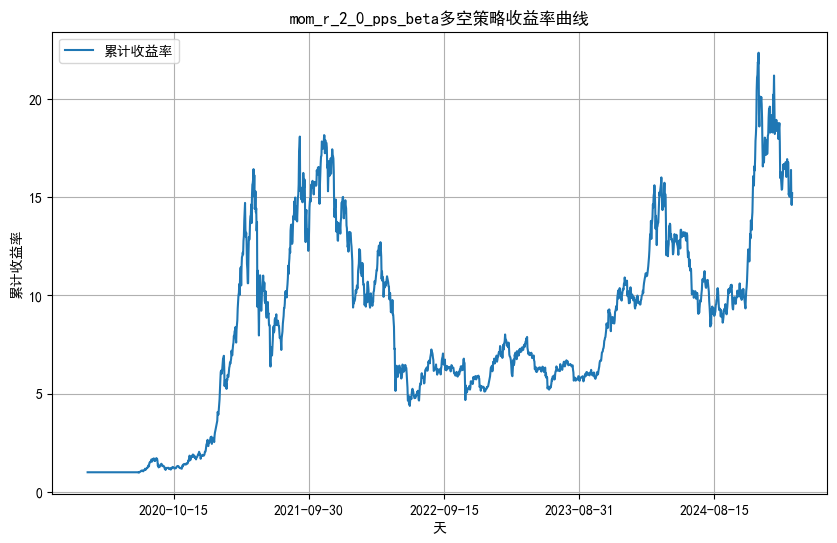

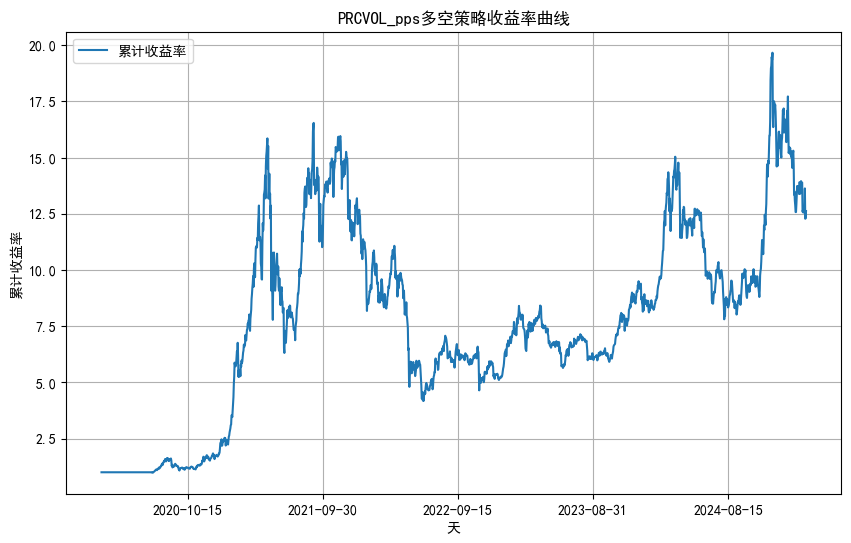

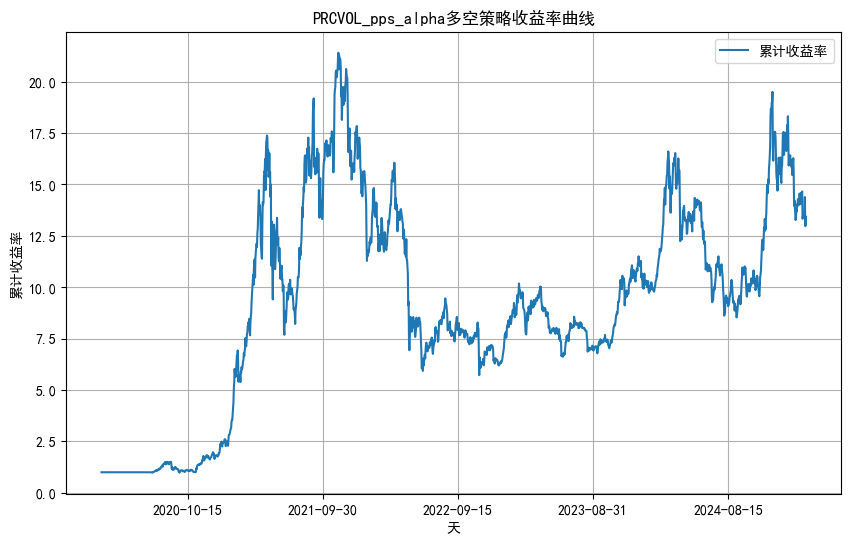

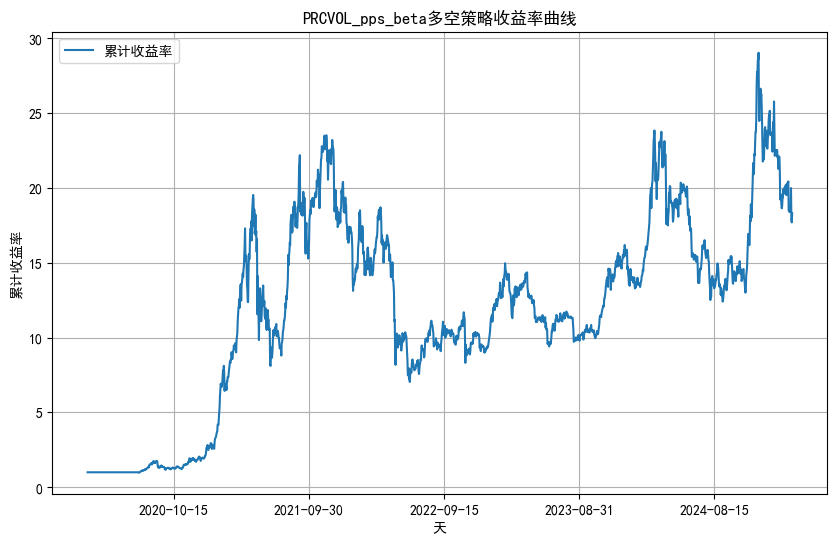

In [3]:
# import sys
# sys.path.append('./')

# from zis_strategy import *

# __eps__ = 1e-10


def rolling_window(matrix_list, window_size=120):
    average_list = []

    for t in range(len(matrix_list)):
        if t < window_size:
            avg_matrix = np.zeros_like(matrix_list[0])
        else:
            matrix = np.array(matrix_list[t-window_size:t])
            avg_matrix = np.mean(matrix, axis=0)
        
        average_list.append(avg_matrix)

    return average_list



class pps():
    '''
    PPS策略: 实现pps优化策略和alpha，beta分解
    '''
    def __init__(self, crypto_currency_list):
        ## 初始化不进行数据转换，保留天数据
        self.cc_class_list = crypto_currency_list
        self.time_list = self.cc_class_list[0].df['timestamp'].unique()
        self.cc_list = [cc.name for cc in self.cc_class_list]

    def get_factor_matrix(self, factor='MCAP'):
        # 生成因子矩阵
        factor_matrix = [[float(c.df[c.df['timestamp']==t][factor].values) for c in self.cc_class_list] for t in self.time_list]
        factor_df = pd.DataFrame(factor_matrix, columns=self.cc_list, index=self.time_list).T
        self.factor_df = factor_df
        # return factor_df
    

    def get_return_matrix(self):
        # 生成收益率矩阵
        return_matrix = [[float(c.df[c.df['timestamp']==t]['daily_return'].values) for c in self.cc_class_list] for t in self.time_list]
        return_df = pd.DataFrame(return_matrix, columns=self.cc_list, index=self.time_list).T
        self.return_df = return_df

    def get_predictor_matrix(self, factor='MCAP'):
        # 预测矩阵由收益向量与因子向量相乘(ps: 收益矩阵计算时已经滞后一期，所以不需要再滞后)
        # 原始预测矩阵
        print('开始计算return matrix...')
        self.get_return_matrix()
        return_df = self.return_df.copy()
        print('开始计算factor matrix...')
        self.get_factor_matrix(factor)
        factor_df = self.factor_df.copy()

        # 用一个list存储每一天的预测矩阵
        print('开始计算rolling pred return matrix...')
        rolling_pred_return_matrix = []
        for i in range(len(return_df.columns)):
            # 每一天的预测矩阵
            R = return_df.iloc[:, i]
            S = factor_df.iloc[:, i]
            pred_return_matrix = np.outer(R, S)
            if np.all(np.isnan(pred_return_matrix)):
                # 如果全为 NaN，则赋值为 0
                pred_return_matrix = np.zeros_like(pred_return_matrix)

            rolling_pred_return_matrix.append(pred_return_matrix)
        
        ## 接下来需要滑窗120天，作为每一天的估计预测矩阵，即每一天的预测矩阵是由前120天的数据得到的

        ## 滑窗120天
        avg_rolling_list = rolling_window(rolling_pred_return_matrix, window_size=120)

        self.avg_rolling_list = avg_rolling_list
        return avg_rolling_list

    def get_svd_weight(self, st, matrix, k=3):
        
        U, Sigma, VT = np.linalg.svd(matrix)     
        weight = np.zeros_like(st)
        
        for i in range(k): ## 取前k个组合的和
            v_k = VT[:, i]
            u_k = U[i, :]
            if np.count_nonzero(matrix) == 0:
                ## 如果矩阵全为0，则返回全0
                weight_k = np.zeros_like(st.T@np.outer(v_k, u_k))
            else:
                weight_k = st.T@np.outer(v_k, u_k)
            
            weight = weight + weight_k

        if np.count_nonzero(weight) != 0:
            # 对权重缩放到和零投资策略的权重之和
            positive_numbers = [x for x in weight if x > 0]
            negative_numbers = [x for x in weight if x < 0]
            sum_positive = sum(positive_numbers)
            sum_negative = sum(negative_numbers)

            weight = [0.5*x/sum_positive if x>0 else 0.5*x/sum_negative for x in weight]

        return weight
    

    def get_weight_matrix(self, factor='MCAP'):
        rolling_pred_return_df = self.get_predictor_matrix(factor=factor)
        weight_matrix = []
        for st in range(len(self.factor_df.columns)):
            s = self.factor_df.iloc[:, st].values
            matrix = rolling_pred_return_df[st]
            weight_k = self.get_svd_weight(s, matrix, k=5)
            weight_matrix.append(weight_k)
        
        self.weight_matrix = pd.DataFrame(weight_matrix, columns=self.cc_list, index=self.time_list).T
        
    def zero_investment_stragety(self, factor='MCAP'):
        # 单因子零投资多空策略，计算其收益率
        self.get_weight_matrix(factor=factor)
        self.get_return_matrix()

        ## 周策略，要将每一周的权重设置为该周第一天
        
        df = self.weight_matrix.T.copy()
        df.index = pd.to_datetime(df.index)
        weekly_first = df.resample('W-MON').first()

        daily_filled = weekly_first.resample('D').ffill().reindex(df.index).ffill()
        result = daily_filled.T

        # 哈达玛积计算收益率
        self.strategy_return_df = result * self.return_df
        self.strategy_time_return = self.strategy_return_df.sum(axis=0)


    def get_weight_matrix_alpha(self, factor='MCAP'):
        rolling_pred_return_df = self.get_predictor_matrix(factor=factor)
        weight_matrix = []
        for st in range(len(self.factor_df.columns)):
            s = self.factor_df.iloc[:, st].values
            matrix = rolling_pred_return_df[st]
            matrix = 0.5*(matrix - matrix.T)
            weight_k = self.get_svd_weight(s, matrix, k=5)
            weight_matrix.append(weight_k)
        
        self.weight_matrix_alpha = pd.DataFrame(weight_matrix, columns=self.cc_list, index=self.time_list).T
    

    def alpha_investment(self, factor='MCAP'):
        # alpha分解
        self.get_return_matrix()
        self.get_weight_matrix_alpha(factor=factor)

        df = self.weight_matrix_alpha.T.copy()
        df.index = pd.to_datetime(df.index)
        weekly_first = df.resample('W-MON').first()

        daily_filled = weekly_first.resample('D').ffill().reindex(df.index).ffill()
        result = daily_filled.T

        # 哈达玛积计算收益率
        self.strategy_return_df_alpha = result * self.return_df
        self.strategy_time_return_alpha = self.strategy_return_df_alpha.sum(axis=0)


    def get_weight_matrix_beta(self, factor='MCAP'):
        rolling_pred_return_df = self.get_predictor_matrix(factor=factor)
        weight_matrix = []
        for st in range(len(self.factor_df.columns)):
            s = self.factor_df.iloc[:, st].values
            matrix = rolling_pred_return_df[st]
            matrix = 0.5*(matrix + matrix.T)
            weight_k = self.get_svd_weight(s, matrix, k=5)
            weight_matrix.append(weight_k)
        
        self.weight_matrix_beta = pd.DataFrame(weight_matrix, columns=self.cc_list, index=self.time_list).T
    
    def beta_investment(self, factor='MCAP'):
        # beta分解
        self.get_return_matrix()
        self.get_weight_matrix_beta(factor=factor)

        df = self.weight_matrix_beta.T.copy()
        df.index = pd.to_datetime(df.index)
        weekly_first = df.resample('W-MON').first()

        daily_filled = weekly_first.resample('D').ffill().reindex(df.index).ffill()
        result = daily_filled.T

        # 哈达玛积计算收益率
        self.strategy_return_df_beta = result * self.return_df
        self.strategy_time_return_beta = self.strategy_return_df_beta.sum(axis=0)

def get_eval_result_daily(df, factor='factor'):
    df['cumulative_return'] = (1 + df['daily_return']).cumprod()

    # 计算年化收益率
    annualized_return = (df['cumulative_return'].iloc[-1]) ** (365 / len(df)) - 1

    # 计算夏普比率（假设无风险利率为0）
    sharpe_ratio = np.sqrt(365) * (df['daily_return'].mean() / (df['daily_return'].std()+__eps__))

    # 计算最大回撤
    df['cumulative_max'] = df['cumulative_return'].cummax()
    df['drawdown'] = df['cumulative_return'] / df['cumulative_max'] - 1
    max_drawdown = df['drawdown'].min()

    # 计算卡玛比率
    calmar_ratio = annualized_return / abs(max_drawdown+__eps__)

    print(f"年化收益率: {annualized_return:.4f}")
    print(f"夏普比率: {sharpe_ratio:.4f}")
    print(f"卡玛比率: {calmar_ratio:.4f}")

    # 绘制收益率曲线
    plt.figure(figsize=(10, 6))
    plt.plot(df['cumulative_return'], label='累计收益率')
    plt.title('收益率曲线')
    plt.xlabel('天')
    plt.ylabel('累计收益率')
    plt.legend()
    plt.grid()
    plt.title(f"{factor}多空策略收益率曲线")

    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(350))  

    # plt.show()
    folder_path = "./figures/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.savefig(f"{folder_path}{factor}.png")



if __name__ == '__main__':
    folder_path = "./data/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    cc_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    def cc_preprocess(cc):
        # 正则匹配
        pattern = r"^code(\d+)_(.+)\.csv$"
        match = re.match(pattern, cc)
        # 实例化
        number = match.group(1)
        name = match.group(2)
        test = crypto_currency(number, name, file_path=folder_path)
        test.get_daily_return()
        test.get_weekly_return()
        # 计算predictor
        test_predictor = predictor(test)
        test_predictor.get_predictor_MCAP()
        test_predictor.get_predictor_MAXDPRC()
        test_predictor.get_predictor_mom_r_1_0()
        test_predictor.get_predictor_mom_r_2_0()
        test_predictor.get_predictor_PRCVOL()

        return test_predictor.crypto_currency

    test_list = []
    for cc in tqdm(cc_list[:], desc='加密货币计算因子中...'):
        test_list.append(cc_preprocess(cc))


    test_zis = pps(test_list)
    test_zis.zero_investment_stragety(factor='MCAP')
    print(f"MCAP策略的天平均收益率为{test_zis.strategy_time_return.mean()}")
    # factor指的是用于画图的title命名
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return, columns=['daily_return']), factor='MCAP_pps')

    test_zis.alpha_investment(factor='MCAP')
    print(f"MCAP策略-alpha的天平均收益率为{test_zis.strategy_time_return_alpha.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_alpha, columns=['daily_return']), factor='MCAP_pps_alpha')

    test_zis.beta_investment(factor='MCAP')
    print(f"MCAP策略-beta的天平均收益率为{test_zis.strategy_time_return_beta.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_beta, columns=['daily_return']), factor='MCAP_pps_beta')


    test_zis.zero_investment_stragety(factor='MAXDPRC')
    print(f"MAXDPRC策略的天平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return, columns=['daily_return']), factor='MAXDPRC_pps')

    test_zis.alpha_investment(factor='MAXDPRC')
    print(f"MAXDPRC策略-alpha的天平均收益率为{test_zis.strategy_time_return_alpha.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_alpha, columns=['daily_return']), factor='MAXDPRC_pps_alpha')

    test_zis.beta_investment(factor='MAXDPRC')
    print(f"MAXDPRC策略-beta的天平均收益率为{test_zis.strategy_time_return_beta.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_beta, columns=['daily_return']), factor='MAXDPRC_pps_beta')

    test_zis.zero_investment_stragety(factor='mom_r_1_0')
    print(f"mom_r_1_0策略的天平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return, columns=['daily_return']), factor='mom_r_1_0_pps')

    test_zis.alpha_investment(factor='mom_r_1_0')
    print(f"mom_r_1_0策略-alpha的天平均收益率为{test_zis.strategy_time_return_alpha.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_alpha, columns=['daily_return']), factor='mom_r_1_0_pps_alpha')

    test_zis.beta_investment(factor='mom_r_1_0')
    print(f"mom_r_1_0策略-beta的天平均收益率为{test_zis.strategy_time_return_beta.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_beta, columns=['daily_return']), factor='mom_r_1_0_pps_beta')

    test_zis.zero_investment_stragety(factor='mom_r_2_0')
    print(f"mom_r_2_0策略的天平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return, columns=['daily_return']), factor='mom_r_2_0_pps')

    test_zis.alpha_investment(factor='mom_r_2_0')
    print(f"mom_r_2_0策略-alpha的天平均收益率为{test_zis.strategy_time_return_alpha.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_alpha, columns=['daily_return']), factor='mom_r_2_0_pps_alpha')

    test_zis.beta_investment(factor='mom_r_2_0')
    print(f"mom_r_2_0策略-beta的天平均收益率为{test_zis.strategy_time_return_beta.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_beta, columns=['daily_return']), factor='mom_r_2_0_pps_beta')

    test_zis.zero_investment_stragety(factor='PRCVOL')
    print(f"PRCVOL策略的天平均收益率为{test_zis.strategy_time_return.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return, columns=['daily_return']), factor='PRCVOL_pps')

    test_zis.alpha_investment(factor='PRCVOL')
    print(f"PRCVOL策略-alpha的天平均收益率为{test_zis.strategy_time_return_alpha.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_alpha, columns=['daily_return']), factor='PRCVOL_pps_alpha')

    test_zis.beta_investment(factor='PRCVOL')
    print(f"PRCVOL策略-beta的天平均收益率为{test_zis.strategy_time_return_beta.mean()}")
    get_eval_result_daily(pd.DataFrame(test_zis.strategy_time_return_beta, columns=['daily_return']), factor='PRCVOL_pps_beta')
